<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/autoencoder-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Autoencoder on MNIST data with TensorFlow 2

Sources for this notebook
* https://blog.keras.io/building-autoencoders-in-keras.html
* https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

Latent Representation learns abstract concepts about inputs. We show two use cases
1. Semantic dimensionality reduction on images: using latent representation
2. modification of images: example is denoising

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

In [0]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
tf.random.set_seed(42)

In [0]:
!nvidia-smi

Tue Dec 31 10:36:02 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import numpy as np
np.random.seed(42)

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [0]:
from lrcurve import KerasLearningCurve

## MNIST data set

In [0]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist

x_res = 28
y_res = 28
image_size = x_res * y_res

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

can not use 2d rep as autoencoder needs to spit out flat image

In [0]:
def plot_samples(x, y, n_samples=15, labels=None):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      if labels:
        ax.set_title("{}".format(labels[y[index]]))
      else:
        ax.set_title("{}".format(y[index]))

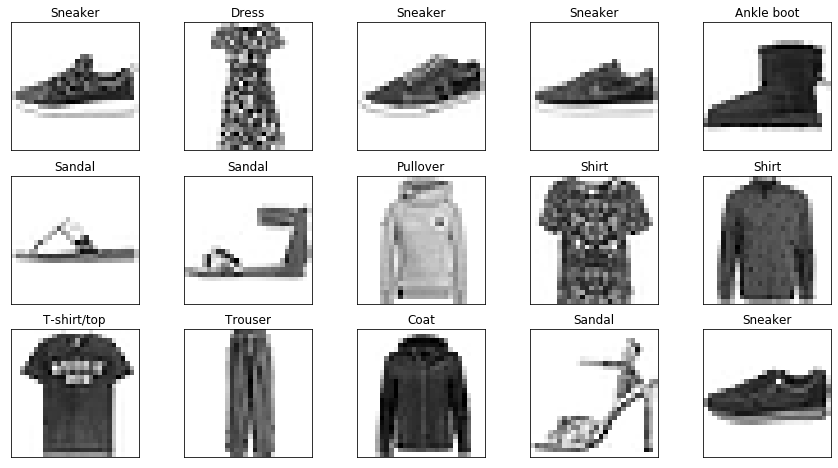

In [0]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


plot_samples(x_train, y_train, labels=fashion_mnist_labels)
# for mnist digits
# plot_samples(x_train, y_train)

### flat autoencoder

_Latent space is constrained by its size only_

In [0]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.models import Model

encoding_dim = 32

input_img = Input(shape=(x_res, y_res), name='2d_input')
flattened = Flatten(name='flattened_input')(input_img)
encoded = Dense(encoding_dim, activation='relu', name='encoder')(flattened)
decoded = Dense(image_size, activation='sigmoid', name='decoder')(encoded)
reshaped = Reshape((x_res, y_res), name='2d_output')(decoded)

autoencoder = Model(input_img, reshaped)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
2d_input (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flattened_input (Flatten)    (None, 784)               0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
_________________________________________________________________
2d_output (Reshape)          (None, 28, 28)            0         
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow import keras

@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [0]:
%%time

BATCH_SIZE = 256
EPOCHS = 25

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])
# also possible
# autoencoder.compile(optimizer='adam', loss='mse', metrics=[rounded_accuracy])

history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 37.7 s, sys: 3.72 s, total: 41.5 s
Wall time: 28.4 s


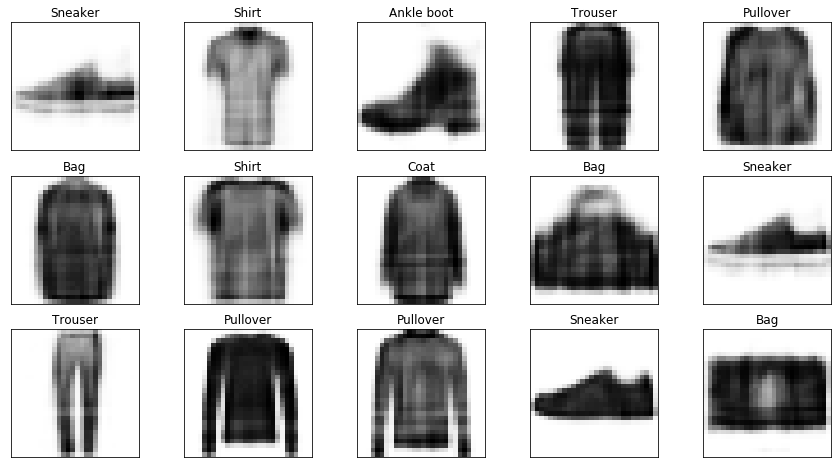

In [0]:
x_test_pred = autoencoder.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# for mnist
# plot_samples(x_test_pred, y_test)

In [0]:
def compare_samples(x, x_pred, n_samples=5):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      ax.imshow(x_pred[index].reshape(x_res, y_res), cmap="binary")

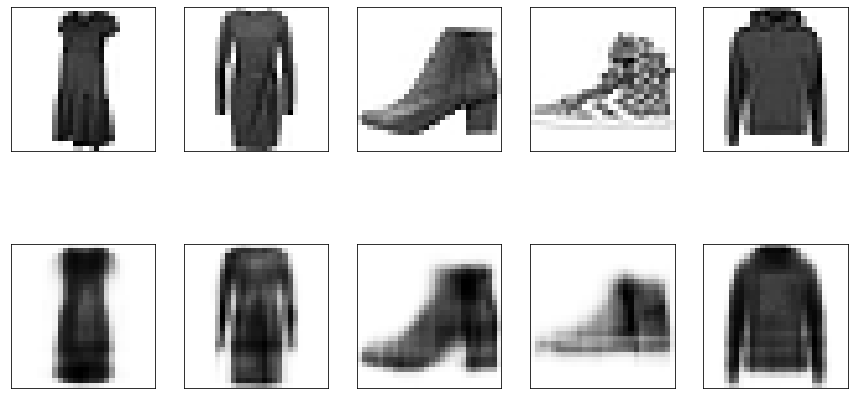

In [0]:
compare_samples(x_test, x_test_pred)

## let's consider the sparsity of an embedding 
### how big are the embeddings on avearge and how many zeros do the embeddings contain on average

In [0]:
encoder = Model(input_img, encoded)
embedded_imgs = encoder.predict(x_test)

In [0]:
embedded_imgs.shape

(10000, 32)

In [0]:
# embedding for first image
embedded_imgs[0]

array([ 2.7818336, 11.767629 ,  3.7490714,  0.       ,  2.7332854,
        2.2524698,  5.028516 ,  0.       ,  2.5412526,  5.038704 ,
        8.099277 , 10.537305 ,  7.6568723,  7.9740963,  2.1093955,
        3.4811234,  9.608813 ,  6.9851446,  8.85762  ,  9.124496 ,
        5.521023 ,  4.5447283, 10.2439165,  5.8350973,  2.420796 ,
        3.6482284,  6.288719 ,  1.4407089,  3.631763 ,  6.5838957,
        1.3230331,  3.7988694], dtype=float32)

In [0]:
tf.reduce_mean(embedded_imgs)

<tf.Tensor: shape=(), dtype=float32, numpy=5.145208>

In [0]:
# how many zeros do the embeddings contain on average
tf.reduce_mean(encoding_dim - tf.math.count_nonzero(embedded_imgs, axis=1))

<tf.Tensor: shape=(), dtype=int64, numpy=3>

## Exercise

Experiment with
* the size of the embedding
* MSE as a loss function
* mnist digits dataset instead of fashin mninst

# STOP HERE

## Sparsity autoencoder

_Latent space is also constrained by allowing only a fraction of neurons to fire for each input_

we use l1 regularization for that

In [0]:
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = Input(shape=(x_res, y_res), name='2d_input')
flattened = Flatten(name='flattened_input')(input_img)
encoded = Dense(encoding_dim, activation='relu', name='encoder',
                activity_regularizer=regularizers.l1(1e-3)
               )(flattened)

decoded = Dense(image_size, activation='sigmoid', name='decoder')(encoded)
reshaped = Reshape((x_res, y_res), name='2d_output')(decoded)

autoencoder = Model(input_img, reshaped)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
2d_input (InputLayer)        [(None, 28, 28)]          0         
_________________________________________________________________
flattened_input (Flatten)    (None, 784)               0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
_________________________________________________________________
2d_output (Reshape)          (None, 28, 28)            0         
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [0]:
%%time 

BATCH_SIZE = 256
EPOCHS = 50

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])

history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 20s, sys: 7.87 s, total: 1min 28s
Wall time: 59.6 s


In [0]:
encoder = Model(input_img, encoded)
embedded_imgs = encoder.predict(x_test)

numbers of zeros should go up, while average should go down

In [0]:
# embedding for first image
embedded_imgs[0]

array([0.        , 0.        , 0.6804031 , 0.        , 0.        ,
       0.        , 1.642199  , 0.2708394 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01555037, 0.54179037, 0.40660584, 0.        ,
       0.        , 0.        , 1.2881383 , 0.08898161, 0.13805163,
       1.1776576 , 0.        , 0.        , 0.        , 0.        ,
       0.55716836, 0.        ], dtype=float32)

In [0]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(encoding_dim - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.19899377>,
 <tf.Tensor: shape=(), dtype=int64, numpy=19>)

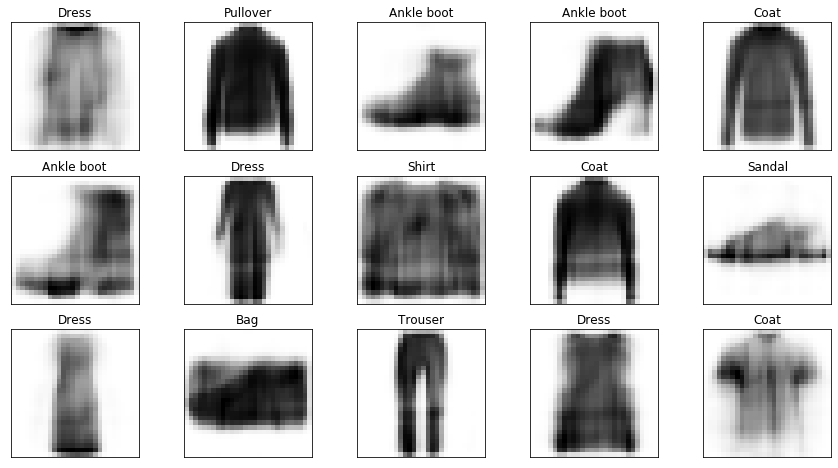

In [0]:
x_test_pred = autoencoder.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# for mnist
# plot_samples(x_test_pred, y_test)

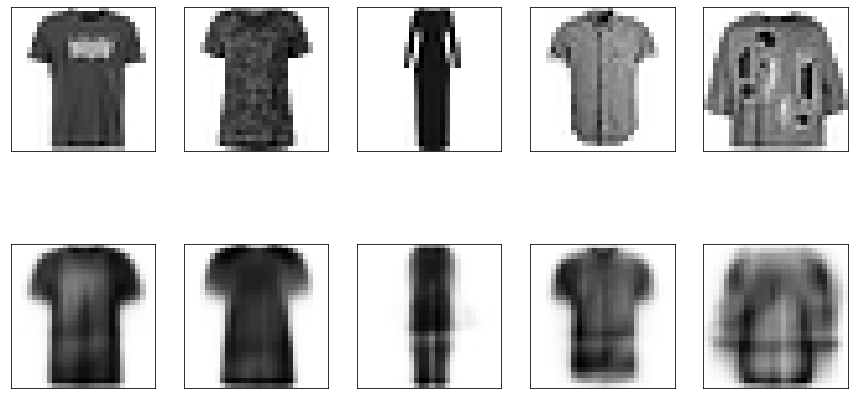

In [0]:
compare_samples(x_test, x_test_pred)

## Deeper Autoencoder
https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [0]:
%%time

BATCH_SIZE = 256
EPOCHS = 20

encoding_dim = 32

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(5e-4)),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)


CPU times: user 34.4 s, sys: 3.25 s, total: 37.7 s
Wall time: 26 s


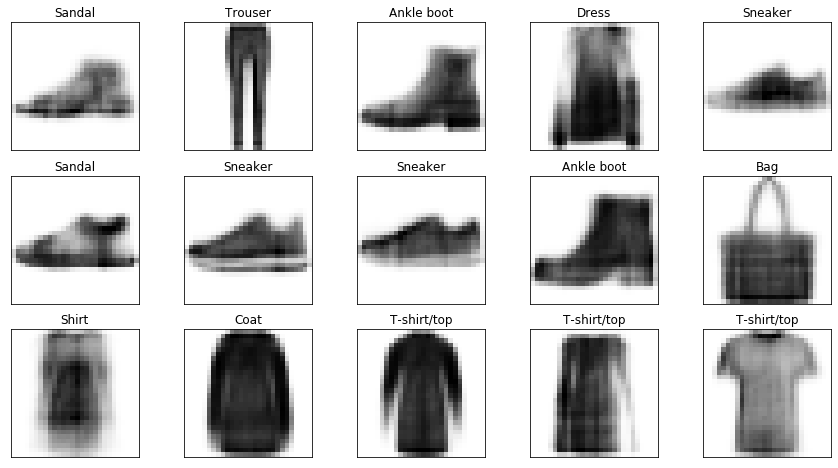

In [0]:
x_test_pred = stacked_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

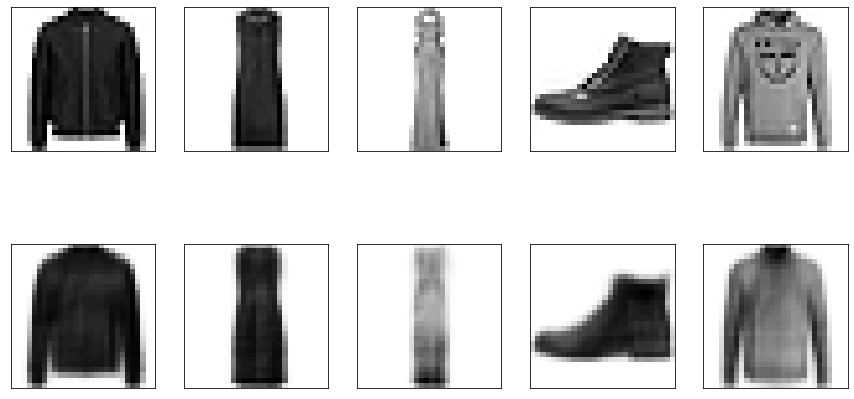

In [0]:
compare_samples(x_test, x_test_pred)

In [0]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 32)

In [0]:
embedded_imgs[0]

array([0.        , 0.        , 0.        , 0.        , 0.95152855,
       1.0626085 , 0.        , 0.        , 0.        , 0.        ,
       0.01203297, 0.        , 0.        , 0.71536016, 0.        ,
       0.        , 0.6330351 , 2.7712522 , 0.23240323, 1.3210789 ,
       0.        , 0.3548891 , 0.25768542, 0.        , 0.5312497 ,
       0.71084577, 0.79688615, 0.17092788, 0.        , 0.38373482,
       0.        , 0.        ], dtype=float32)

In [0]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(encoding_dim - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.28189537>,
 <tf.Tensor: shape=(), dtype=int64, numpy=16>)

## Looking at our embeddings

need to reduce to 2 dim to make them plotable

In [0]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
import umap

In [0]:
%%time

# https://umap-learn.readthedocs.io/en/latest/parameters.html
reducer = umap.UMAP(
#     n_neighbors=50, 
    random_state=42)
embeddings_2d = reducer.fit_transform(embedded_imgs)

CPU times: user 33.6 s, sys: 297 ms, total: 33.9 s
Wall time: 33.3 s


In [0]:
embeddings_2d.shape

(10000, 2)

In [0]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

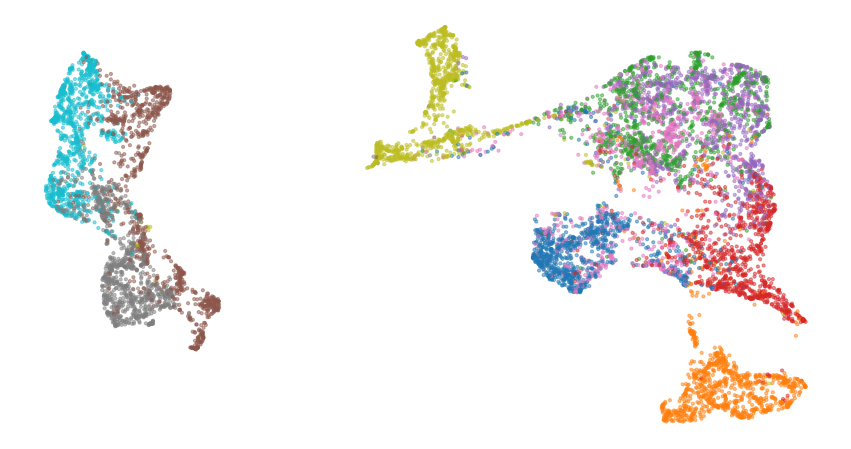

In [0]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap="tab10", alpha=0.5)
plt.axis("off");

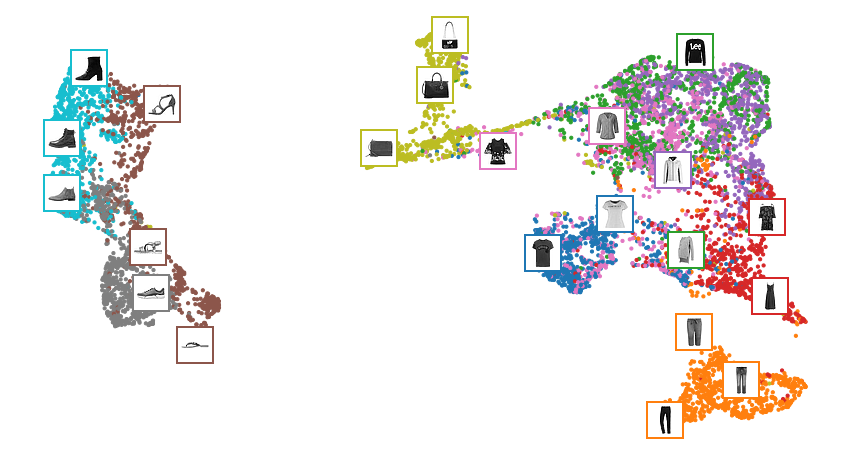

In [0]:
# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.2: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Exercise: Can you explain the 2d plot?

* Are all classes seperated in equal quality?
* Try with mnist digits as well
* What differences do you see?
* Can you explain?

# STOP HERE

## Using 2d embeddings directly without UMAP dimensionality reduction

_using l2 regularization to balance out embeddings_

In [0]:
%%time

BATCH_SIZE = 4096
EPOCHS = 100

encoding_dim = 2

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(encoding_dim, activation="relu",
                       activity_regularizer=keras.regularizers.l2(1e-4)
                      )
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)


CPU times: user 44.4 s, sys: 2.73 s, total: 47.1 s
Wall time: 30.6 s


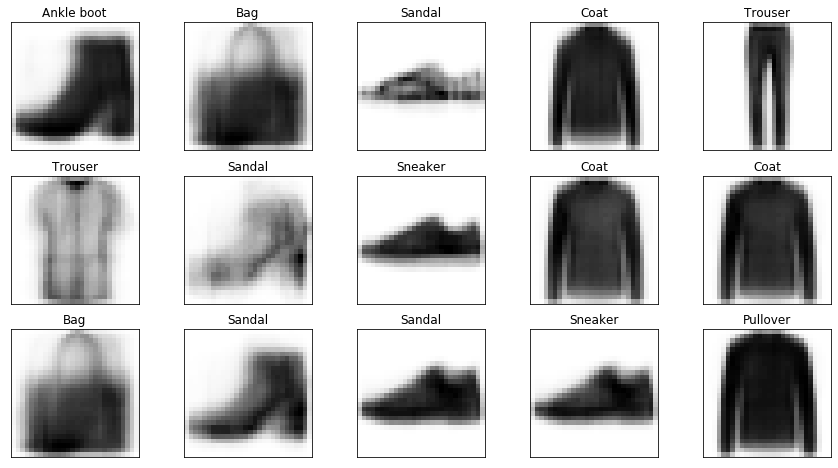

In [0]:
x_test_pred = stacked_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

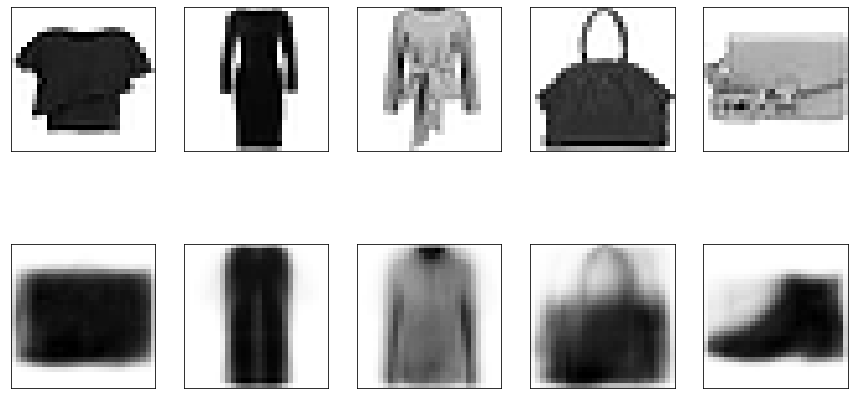

In [0]:
compare_samples(x_test, x_test_pred)

In [0]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 2)

In [0]:
embedded_imgs[0]

array([0.50078106, 2.3756404 ], dtype=float32)

In [0]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(2.0 - tf.cast(tf.math.count_nonzero(embedded_imgs, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=1.6914335>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0353>)

In [0]:
embeddings_2d = embedded_imgs

In [0]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

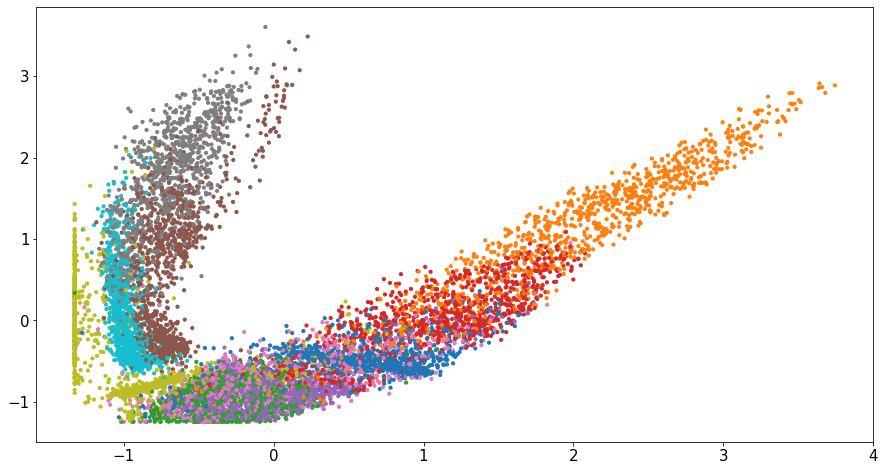

In [0]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap);
# plt.axis("off");

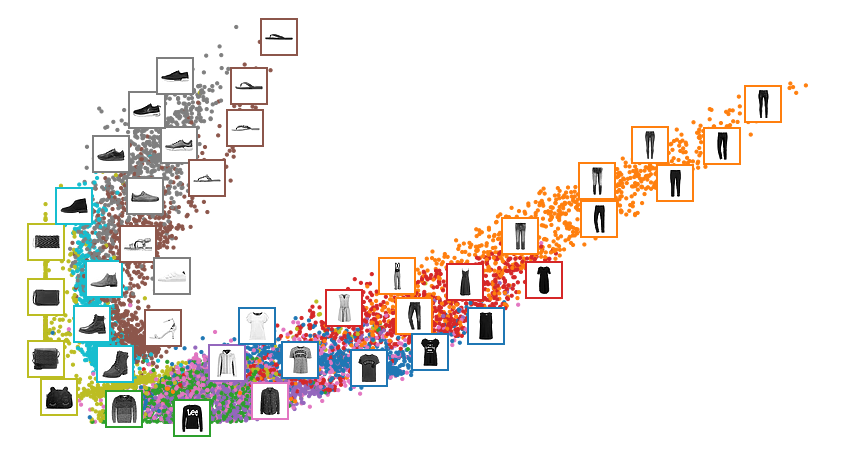

In [0]:
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Convolutional Autoencoders

_might have better results on imgages_

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model, Sequential

conv_encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2)
])

# https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/
conv_decoder = Sequential([
    Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="relu",
                                 input_shape=[3, 3, 64]),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="relu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

In [0]:
%%time

BATCH_SIZE = 2048
EPOCHS = 50

history = conv_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 38 s, sys: 8.89 s, total: 46.9 s
Wall time: 47.8 s


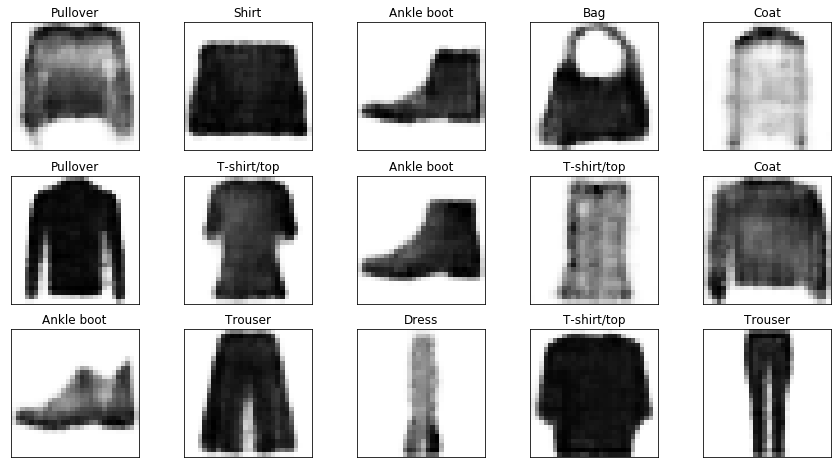

In [0]:
x_test_pred = conv_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

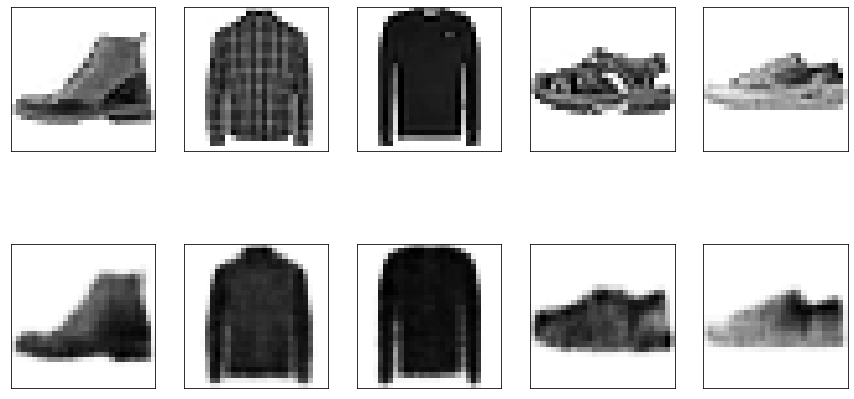

In [0]:
compare_samples(x_test, x_test_pred)

## Now putting an explicit latent space in between as a bottleneck

In [0]:
# the most important part: decide between direct embedding (2) and umap (32)
encoding_dim = 32
# encoding_dim = 2

In [0]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model, Sequential

conv_encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(encoding_dim, activation="relu", 
          activity_regularizer=keras.regularizers.l2(1e-4)
         ),

])
conv_decoder = Sequential([
    Input(shape=(encoding_dim)),
    Reshape((1, 1, encoding_dim)),
    Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", activation="relu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)         

In [0]:
%%time

BATCH_SIZE = 2048
EPOCHS = 50

history = conv_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 38.6 s, sys: 7.81 s, total: 46.4 s
Wall time: 44.6 s


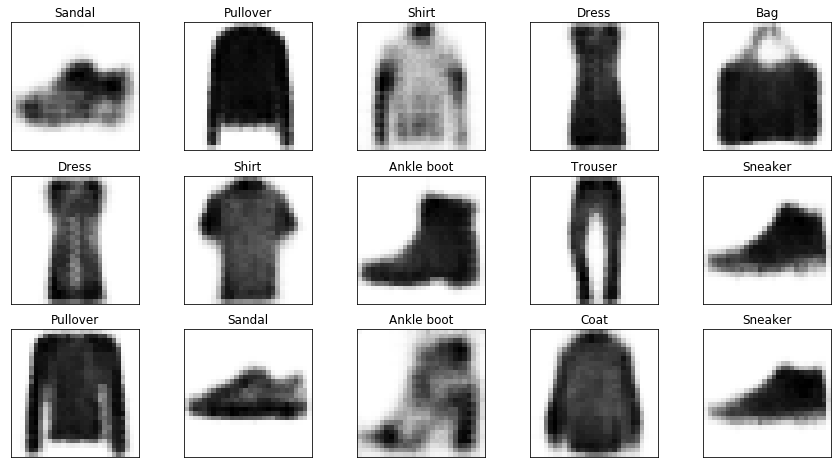

In [0]:
x_test_pred = conv_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)
# plot_samples(x_test_pred, y_test)

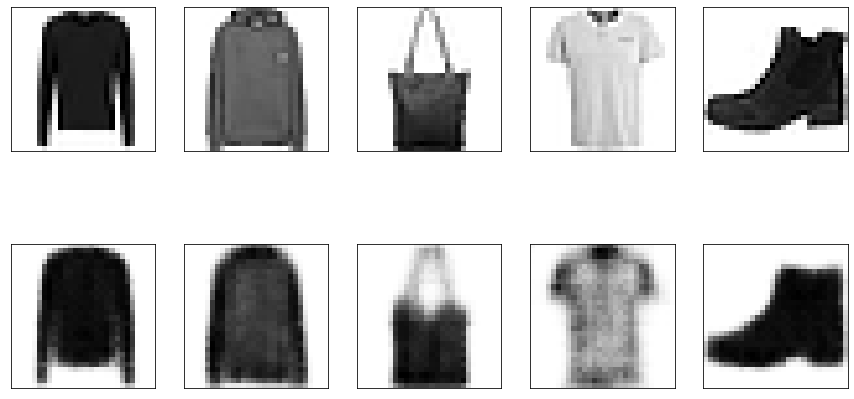

In [0]:
compare_samples(x_test, x_test_pred)

In [0]:
embedded_imgs = conv_encoder.predict(x_test)
embedded_imgs.shape

(10000, 32)

In [0]:
embedded_imgs[0]

array([0.1674429 , 0.8644531 , 0.04760114, 0.7241719 , 1.7877208 ,
       0.        , 0.        , 0.8360711 , 1.0192733 , 0.        ,
       1.157627  , 0.4203492 , 0.        , 1.3021624 , 0.15453747,
       0.4884417 , 0.40026116, 0.        , 0.22577351, 0.        ,
       0.        , 1.2290498 , 0.27633405, 0.        , 1.0830123 ,
       0.79005516, 0.        , 0.        , 0.7611545 , 0.5168268 ,
       0.07152677, 0.15246412], dtype=float32)

In [0]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(encoding_dim - tf.cast(tf.math.count_nonzero(embedded_imgs, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.41684794>,
 <tf.Tensor: shape=(), dtype=float32, numpy=12.6569>)

In [0]:
%%time

if encoding_dim == 2:
  embeddings_2d = embedded_imgs
else:
  print('reducing dim using umap')
  reducer = umap.UMAP(random_state=42)
  embeddings_2d = reducer.fit_transform(embedded_imgs)

reducing dim using umap
CPU times: user 29.7 s, sys: 306 ms, total: 30 s
Wall time: 29.4 s


In [0]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

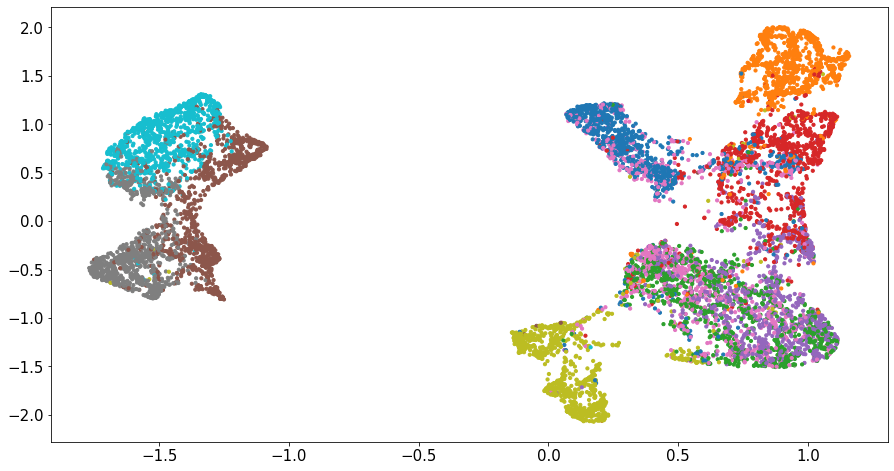

In [0]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap);

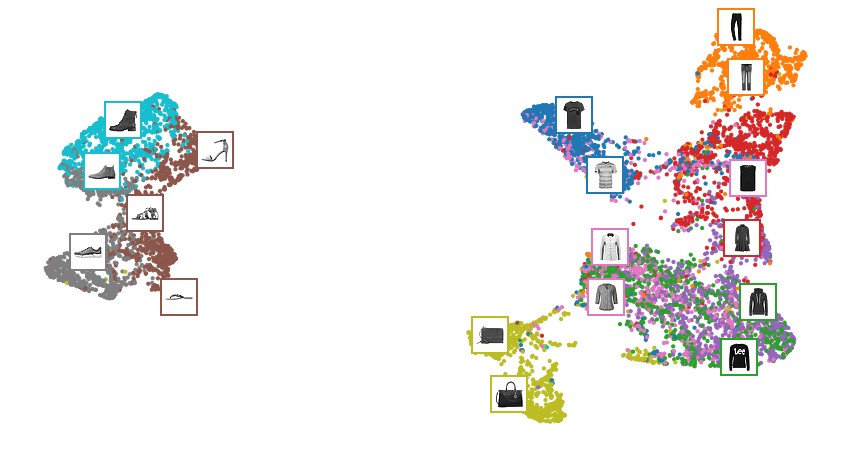

In [0]:
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Exercise: 
* Use other data set (if you are using digits use fashion and the other way around)
* Switch between 2d and 32d plus umap embedding

# STOP HERE